In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/gdrive


In [2]:
!unzip /content/drive/MyDrive/Train.zip

Archive:  /content/drive/MyDrive/Train.zip
   creating: Train/high/
  inflating: Train/high/.DS_Store    
  inflating: Train/high/10.png       
  inflating: Train/high/100.png      
  inflating: Train/high/101.png      
  inflating: Train/high/102.png      
  inflating: Train/high/103.png      
  inflating: Train/high/104.png      
  inflating: Train/high/105.png      
  inflating: Train/high/106.png      
  inflating: Train/high/107.png      
  inflating: Train/high/109.png      
  inflating: Train/high/110.png      
  inflating: Train/high/112.png      
  inflating: Train/high/113.png      
  inflating: Train/high/114.png      
  inflating: Train/high/115.png      
  inflating: Train/high/116.png      
  inflating: Train/high/117.png      
  inflating: Train/high/118.png      
  inflating: Train/high/119.png      
  inflating: Train/high/12.png       
  inflating: Train/high/120.png      
  inflating: Train/high/121.png      
  inflating: Train/high/122.png      
  inflating: Train/h

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        # Check if the file is an image file before opening
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img = Image.open(os.path.join(folder, filename)).convert('RGB')
            if img is not None:
                img = img.resize((32, 32))  # Resize to 32x32
                images.append(np.array(img))
    return np.array(images)

# Load images from 'low' and 'high' folders
low_dir = '/content/Train/low'
high_dir = '/content/Train/high'

low_images = load_images_from_folder(low_dir)
high_images = load_images_from_folder(high_dir)

# Normalize images
low_images = low_images.astype('float32') / 255.0
high_images = high_images.astype('float32') / 255.0

# Split into train and test sets
split = int(0.8 * len(low_images))
x_train_noisy = low_images[:split]
x_test_noisy = low_images[split:]
x_train = high_images[:split]
x_test = high_images[split:]

In [4]:
# Build the denoising model
input_img = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Epoch 1/100
13/13 [==============================] - 1s 95ms/step - loss: 0.6280 - val_loss: 0.6320
Epoch 2/100
13/13 [==============================] - 1s 97ms/step - loss: 0.6276 - val_loss: 0.6337
Epoch 3/100
13/13 [==============================] - 1s 97ms/step - loss: 0.6268 - val_loss: 0.6324
Epoch 4/100
13/13 [==============================] - 1s 94ms/step - loss: 0.6265 - val_loss: 0.6320
Epoch 5/100
13/13 [==============================] - 1s 112ms/step - loss: 0.6263 - val_loss: 0.6324
Epoch 6/100
13/13 [==============================] - 2s 148ms/step - loss: 0.6266 - val_loss: 0.6318
Epoch 7/100
13/13 [==============================] - 2s 152ms/step - loss: 0.6261 - val_loss: 0.6324
Epoch 8/100
13/13 [==============================] - 1s 96ms/step - loss: 0.6258 - val_loss: 0.6315
Epoch 9/100
13/13 [==============================] - 1s 96ms/step - loss: 0.6253 - val_loss: 0.6317
Epoch 10/100
13/13 [==============================] - 1s 96ms/step - loss: 0.6251 - val_loss: 0.6

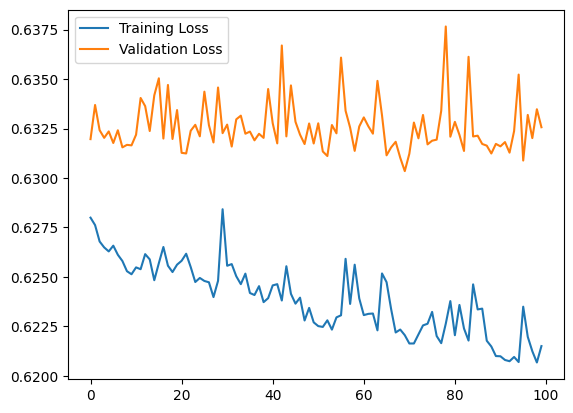

In [16]:
# Plotting training and validation loss
history = autoencoder.fit(x_train_noisy, x_train,
                                   epochs=100,
                                   batch_size=32,
                                   shuffle=True,
                                   validation_data=(x_test_noisy, x_test))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

4/4 [==============================] - 0s 18ms/step
Average PSNR:  18.3303543721465


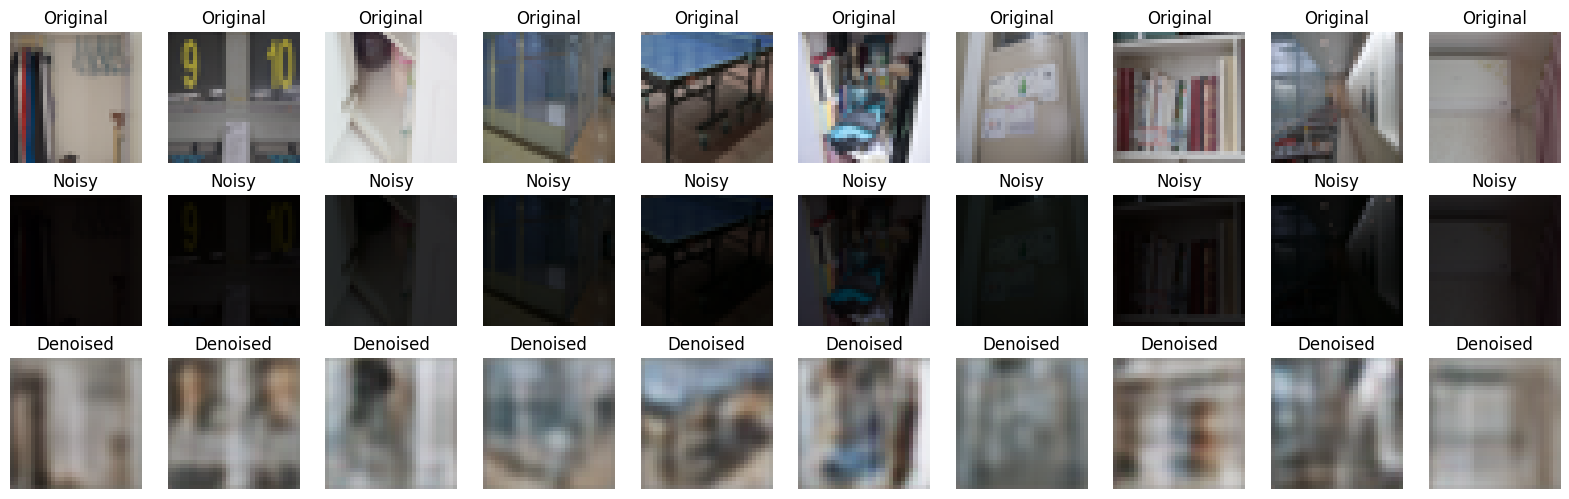

In [11]:
from math import log10, sqrt

# Denoise the test images
x_test_denoised = autoencoder.predict(x_test_noisy)

# Function to calculate PSNR
def psnr(original, denoiced):
    mse = np.mean((original - denoiced) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

# Calculate PSNR for the test set
psnr_scores = [psnr(x_test[i], x_test_denoised[i]) for i in range(len(x_test))]
avg_psnr = np.mean(psnr_scores)
print("Average PSNR: ", avg_psnr)

# Display some results
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test_denoised[i])
    plt.title("Denoised")
    plt.axis("off")
plt.show()